Let's first import a few useful libraries:

In [1]:
import numpy as np
import scipy
from scipy.io import loadmat

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.animation import FuncAnimation
%matplotlib inline

from sklearn.model_selection import train_test_split
from IPython.display import HTML

Simulation results are stored in a Matlab file with a `.mat` format. We're interested in finding a lower dimensional decomposition of the vorticity defined as
$$ \boldsymbol \omega = \nabla \times \mathbf u $$
where $\mathbf u$ is the velocity field with two components $\mathbf u = [u, v]$. Let's first plot the vorticity

In [2]:
results = loadmat('../data/cyl_flow_data.mat')

m = int(results['m'][0][0])
n = int(results['n'][0][0])
v = results['VALL'][:, 0].reshape((n, m))
u = results['UALL'][:, 0].reshape((n, m))
vort = results['VORTALL'][:, 0].reshape((n, m))
tsteps = results['VORTALL'].shape[1]


Use `imshow` for plotting the vorticity at $t=0$

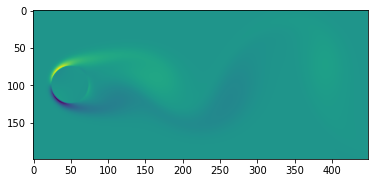

In [3]:
plt.imshow(vort.T)
plt.show()

vortmean = np.mean(results['VORTALL'], axis=1).reshape((n, m)).T

We can also look at the whole simulation by using the matplotlib.animation library

In [4]:
fig = plt.figure()
ax = fig.add_subplot(111)
im = ax.imshow(vort.T, cmap='jet')
# vortmean = np.mean(vort, axis=2)
# update the frames based on the parameter i
def animate(i):
    vort = results['VORTALL'][:, i].reshape((n, m)).T
    im.set_array(vort)
    return [im]

# run the animation
animation = FuncAnimation(fig, animate, frames=tsteps, interval=20)
plt.close()
HTML(animation.to_jshtml())

# New Section

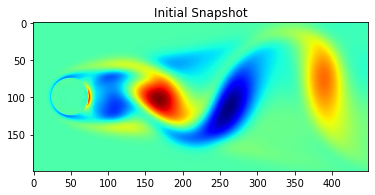

In [5]:
## POD
X = results['VORTALL']
Y = np.concatenate((X, X), axis=1)

for k in range(X.shape[1]):
    # 'F' stands for Fortran-style reshaping, to be consistent with the way MATLAB does it.
    xflip = (np.flipud(X[:, k].reshape((m, n), order='F'))).reshape((m*n,), order='F') 
    Y[:, k+X.shape[1]] = -xflip

Yavg = np.mean(Y, axis=1)
# fig = plt.figure()
# plt.imshow(Yavg.reshape((m, n), order='F'))
# plt.title('Mean Vorticity')

# Subtract average
Ynorm = Y-Yavg.reshape(-1, 1)

fig = plt.figure()
r = 0.1 # 100r% of simulation
plt.imshow(Ynorm[:, int(r*Y.shape[1])].reshape((m, n), order='F'), 'jet')
plt.title('Initial Snapshot')
plt.show()


In [6]:
Ynorm = Y-Yavg.reshape(-1, 1)
[U, S, V] = np.linalg.svd(Ynorm, full_matrices=False)

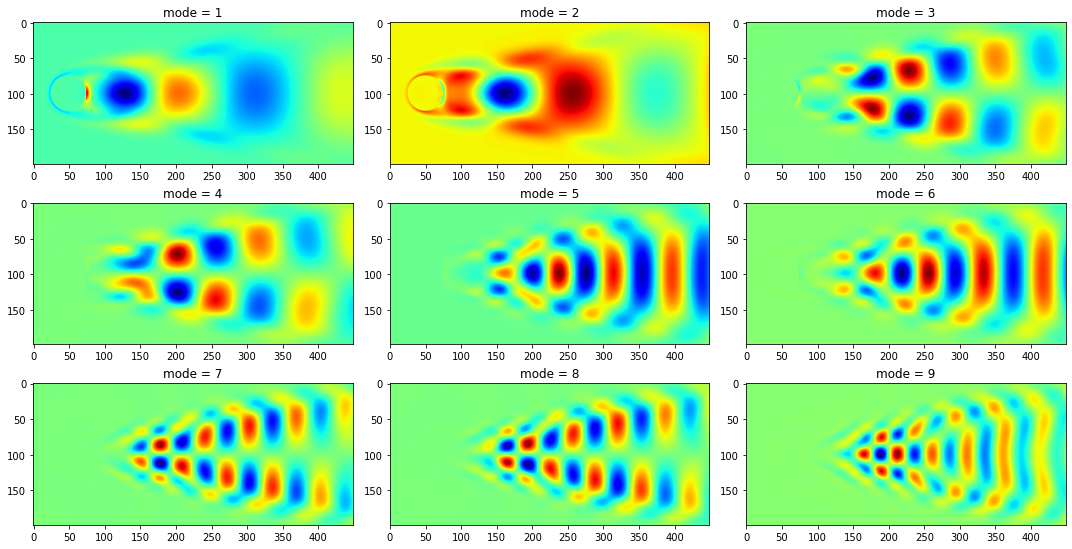

In [7]:
fig = plt.figure(figsize=(15, 10))

for k in range(9):
    uplot = U[:, k].reshape((m, n), order='F')
    ax = fig.add_subplot(4, 3, k+1)
    ax.imshow(uplot, cmap='jet')
    ax.set_title('mode = %d'%(k+1))
plt.tight_layout()
plt.show()

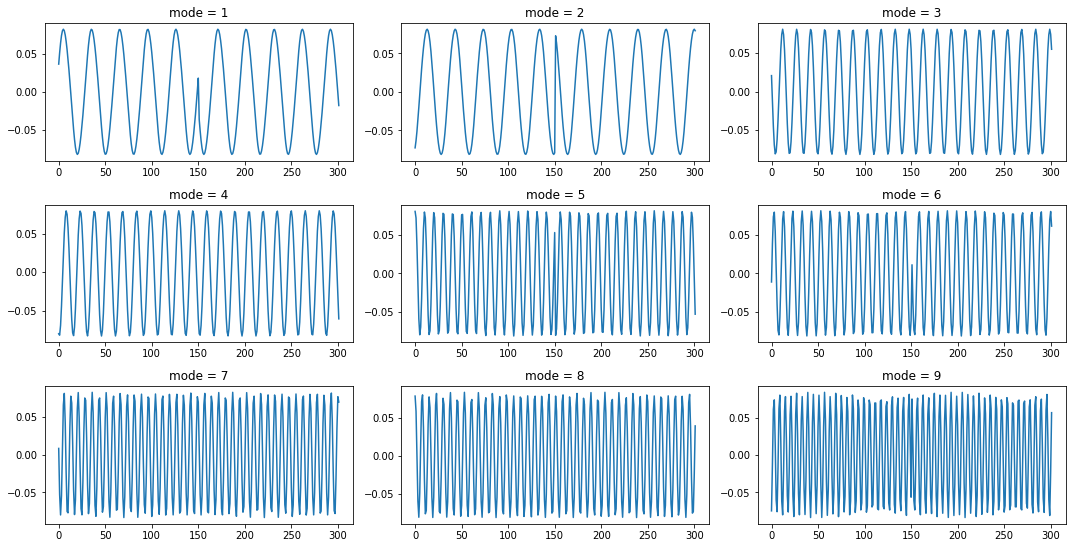

In [8]:
fig = plt.figure(figsize=(15, 10))

for k in range(9):
    uplot = V[k, :]
    ax = fig.add_subplot(4, 3, k+1)
    ax.plot(uplot)
    ax.set_title('mode = %d'%(k+1))
plt.tight_layout()
plt.show()

POD/SVD is a linear dimensionality reduction technique. Its modes are interpretable as the optimal basis for reconstructing the dynamics/data. However, if the data is nonlinear, POD fails to separate it into orthogonal modes. In that case, a nonlinear dimensionality reduction technique is needed. This motivates the use of autoencoders. Check this paper for examples where Autoencoders are better than PCA: https://people.maths.bris.ac.uk/~maxvd/reduce_dim.pdf

Whether nonlinear dimensionality reduction is required in fluids depends on the problem. Let's apply it to the flow around a cylinder problem.

In [9]:
import tensorflow as tf
from tensorflow.keras import layers


class Autoencoder(tf.keras.Model):
    def __init__(self, latent_dim, input_dim, activation='sigmoid'):
        super(Autoencoder, self).__init__()
        self.latent_dim = latent_dim
        self.input_dim = input_dim
        self.activation = activation

        self.encoder = tf.keras.Sequential([
            tf.keras.layers.Dense(int(self.input_dim/2), activation=self.activation),
            tf.keras.layers.Dense(int(self.input_dim/4), activation=self.activation),
            tf.keras.layers.Dense(int(self.input_dim/8), activation=self.activation),
            tf.keras.layers.Dense(self.latent_dim, activation='linear'),
        ]) 
        self.decoder = tf.keras.Sequential([
            tf.keras.layers.Dense(int(self.input_dim/8), activation=self.activation),
            tf.keras.layers.Dense(int(self.input_dim/4), activation=self.activation),
            tf.keras.layers.Dense(int(self.input_dim/2), activation=self.activation),
            tf.keras.layers.Dense(self.input_dim, activation='linear'),
        ]) 

    def call(self, x):
        x       = self.encoder(x)
        decoded = self.decoder(x)
        return decoded

In [10]:
x_train = Ynorm
latent_dim = 10 # number of modes
activation = 'elu'
input_dim = x_train.shape[1]

optimizer = 'adam'
epochs = 50


A = Autoencoder(latent_dim, input_dim, activation)
A.compile(optimizer=optimizer, loss=tf.keras.losses.MeanSquaredError())

In [11]:
x_train.shape

(89351, 302)

In [ ]:
A.fit(x_train, x_train, epochs=epochs, shuffle=True)


In [ ]:
g = A.predict(x_train)
error = np.abs(x_train - g)

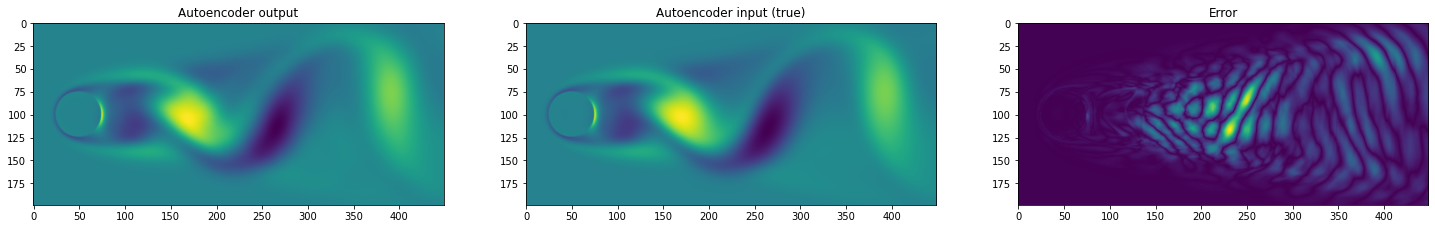

In [ ]:
## Predictions (output of decoder)
sidx = 0 # Snapshot index

fig = plt.figure(figsize=(25, 5))
ax0 = fig.add_subplot(131)
ax0.imshow(g[:, sidx].reshape((m, n), order='F'))
ax0.set_title('Autoencoder output')

ax1 = fig.add_subplot(132)
ax1.imshow(x_train[:, sidx].reshape((m, n), order='F'))
ax1.set_title('Autoencoder input (true)')

ax2 = fig.add_subplot(133)
ax2.imshow(error[:, sidx].reshape((m, n), order='F'))
ax2.set_title('Error')

plt.show()

In [ ]:
auto_modes = A.encoder(x_train)

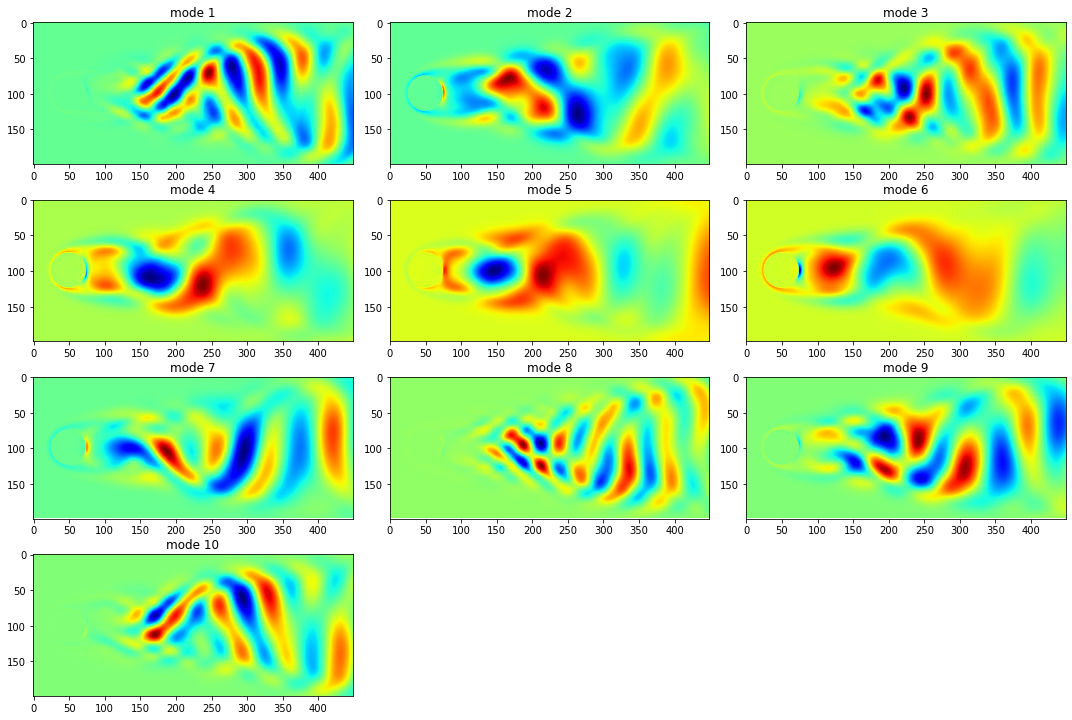

In [ ]:
fig = plt.figure(figsize=(15, 10))

for k in range(10):
    mode = auto_modes[:, k].numpy()
    uplot = mode.reshape((m, n), order='F')
    ax = fig.add_subplot(4, 3, k+1)
    ax.imshow(uplot, cmap='jet')
    ax.set_title('mode %d'%(k+1))
plt.tight_layout()
plt.show()